In [1]:
import torch
import os
import matplotlib.pyplot as plt
os.chdir("..")


from dreamy.models.Temporal.LSTM import LSTMModel
from dreamy.models.Temporal.GRU import GRUModel
from dreamy.models.Temporal.Dlinear import DlinearModel

from dreamy.data import UniversalDataset
from dreamy.utils import utils

# initial settings
device = torch.device('cpu')
torch.manual_seed(7)

lookback = 12 # inputs size
horizon = 3 # predicts size


permute = False

epochs = 50 # training epochs
batch_size = 50 # training batch size

In [6]:

dataset = UniversalDataset()
dataset.load_toy_dataset()


# load toy dataset
dataset = UniversalDataset()
dataset.load_toy_dataset()

device = torch.device('cpu')
# preprocessing
features, mean, std = utils.normalize(dataset.x)
# adj_norm = utils.normalize_adj(dataset.graph)

features = features.to(device)
# adj_norm = adj_norm.to(device)

# prepare datasets
train_rate = 0.6 
val_rate = 0.2

split_line1 = int(features.shape[0] * train_rate)
split_line2 = int(features.shape[0] * (train_rate + val_rate))

train_original_data = features[:split_line1, :, :]
val_original_data = features[split_line1:split_line2, :, :]
test_original_data = features[split_line2:, :, :]

train_input, train_target = dataset.generate_dataset(X = train_original_data, Y = train_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = permute)
val_input, val_target = dataset.generate_dataset(X = val_original_data, Y = val_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = permute)
test_input, test_target = dataset.generate_dataset(X = test_original_data, Y = test_original_data[:, :, 0], lookback_window_size = lookback, horizon_size = horizon, permute = permute)

# Selecting the first region for both input and target
train_input = train_input[:, :, 0, :]  # Selecting the first region across all timesteps and features
train_target = train_target[:, :, 0]  # Selecting the first region for the target

val_input = val_input[:, :, 0, :]
val_target = val_target[:, :, 0]

test_input = test_input[:, :, 0, :]
test_target = test_target[:, :, 0]

# shape of train_input: (num_samples, num_timesteps, num_features)

# prepare model

model = GRUModel(
            num_features=train_input.shape[2],
            num_timesteps_input=lookback,
            num_timesteps_output=horizon
            ).to(device=device)


# model = LSTMModel(
#             num_features = train_input.shape[2],
#             num_timesteps_input = lookback,
#             num_timesteps_output = horizon
#             ).to(device = device)


# model = DlinearModel(
#             num_features=train_input.shape[2],
#             num_timesteps_input=lookback,
#             num_timesteps_output=horizon
#             ).to(device=device)





In [7]:
# training
model.fit(
        train_input = train_input, 
        train_target = train_target, 
        # graph = adj_norm, 
        val_input = val_input, 
        val_target = val_target, 
        verbose = True,
        batch_size = batch_size,
        epochs = epochs)

  8%|▊         | 4/50 [00:00<00:02, 15.57it/s]

######### epoch:0
Training loss: 0.06655601518494743
Validation loss: 0.3852043151855469


100%|██████████| 50/50 [00:02<00:00, 16.87it/s]



Final Training loss: 0.006971108594111034
Final Validation loss: 0.1064029112458229


In [8]:

def get_MAE(pred, target):
    return torch.mean(torch.absolute(pred - target))

# evaluate
out = model.predict(feature = test_input)
preds = out.detach().cpu() * std[0] + mean[0]
targets = test_target.detach().cpu() * std[0] + mean[0]
# MAE
mae = get_MAE(preds, targets)
print(f"MAE: {mae.item()}")



MAE: 38.07352828979492


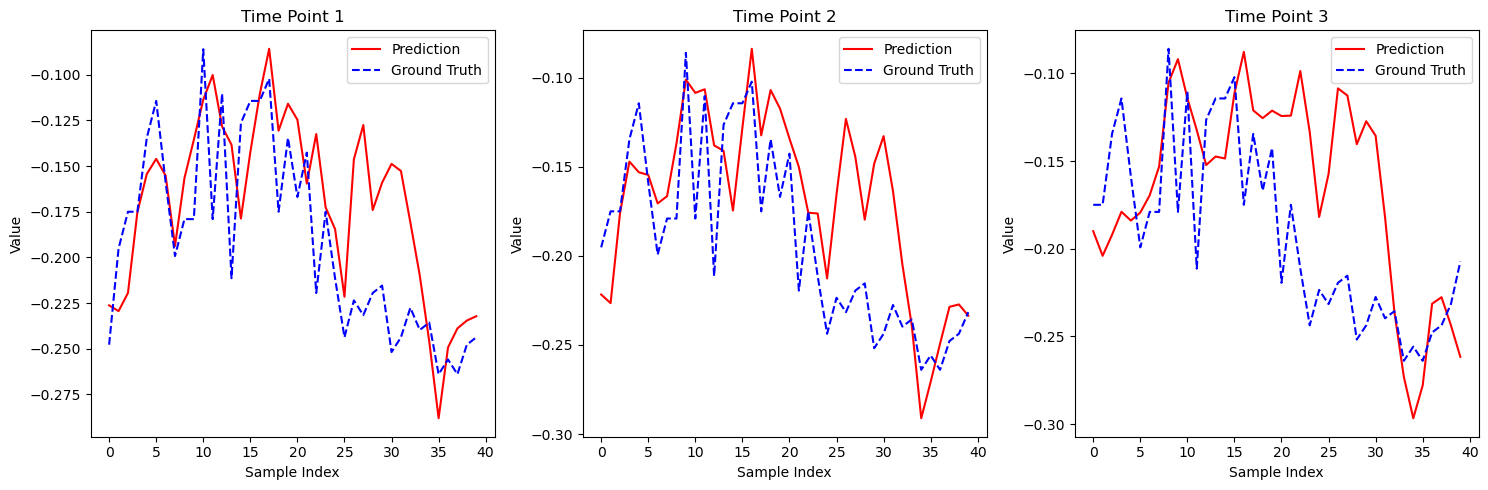

In [9]:
import matplotlib.pyplot as plt
import torch


out = model.predict(feature=train_input).detach().cpu()

num_samples = 40  # Number of samples to display
time_points = 3  # Each sample predicts the next 3 time points

plt.figure(figsize=(15, 5))
for t in range(time_points):
    plt.subplot(1, 3, t + 1)
    
    # Gather all predictions and actual values for the t-th future time point across the first 40 samples
    predictions = out[:num_samples, t]
    truths = train_target[:num_samples, t]

    # Plotting the predictions and ground truth values
    plt.plot(range(num_samples), predictions.numpy(), 'r-', label='Prediction')
    plt.plot(range(num_samples), truths.numpy(), 'b--', label='Ground Truth')
    plt.title(f"Time Point {t + 1}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()


